# Experiments

## Import des fichiers

In [32]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from functools import partial


#Modélisation
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV# the keys can be accessed with final_pipeline.get_params().keys()
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

#Text
import re

#Evaluation
from sklearn.metrics import f1_score, confusion_matrix


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px


#Tracking d'expérience
import mlflow
import mlflow.sklearn

## Utilisation du code du projet packagé

In [4]:
#Cette cellule permet d'appeler la version packagée du projet et d'en assurer le reload avant appel des fonctions
%load_ext autoreload
%autoreload 2

## Configuration de l'experiment MLFlow

In [5]:
mlflow.tracking.get_tracking_uri()

'/mnt/experiments'

## Chargement des données

#### load_mtpl2

In [33]:
def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
    df_freq['IDpol'] = df_freq['IDpol'].astype(int)
    df_freq.set_index('IDpol', inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby('IDpol').sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


#### plot_obs_pred

In [34]:
def plot_obs_pred(df, feature, weight, observed, predicted, y_label=None,
                  title=None, ax=None, fill_legend=False):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


#### score_estimator

In [35]:
def score_estimator(
    estimator, X_train, X_test, df_train, df_test, target, weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [(
            "mean Tweedie dev p={:.4f}".format(power),
            partial(mean_tweedie_deviance, power=power)
        ) for power in tweedie_powers]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res

In [36]:
df = load_mtpl2(n_samples=60000)

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

with pd.option_context("display.max_columns", 15):
    print(df[df.ClaimAmount > 0].head())

       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
139        1.0      0.75    F       7.0     1.0     61.0        50.0      B12   
190        1.0      0.14    B      12.0     5.0     50.0        60.0      B12   
414        1.0      0.14    E       4.0     0.0     36.0        85.0      B12   
424        2.0      0.62    F      10.0     0.0     51.0       100.0      B12   
463        1.0      0.31    A       5.0     0.0     45.0        50.0      B12   

        VehGas  Density Region  ClaimAmount   PurePremium  Frequency  \
IDpol                                                                  
139    Regular  27000.0    R11       303.00    404.000000   1.333333   
190     Diesel     56.0    R25      1981.84  14156.000000   7.142857   
414    Regular   4792.0    R11      1456.55  10403.928571   7.142857   
424    Regular  27000.0    R11     10834.00  17474.193548   3.225806   


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


## Frequency model – Poisson distribution

In [37]:
df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

# The parameters of the model are estimated by minimizing the Poisson deviance
# on the training set via a quasi-Newton solver: l-BFGS. Some of the features
# are collinear, we use a weak penalization to avoid numerical issues.
glm_freq = PoissonRegressor(alpha=1e-3, max_iter=400)
glm_freq.fit(X_train, df_train["Frequency"],
             sample_weight=df_train["Exposure"])

scores = score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0590  0.0579
mean abs. error     0.1706  0.1661
mean squared error  0.3041  0.3043


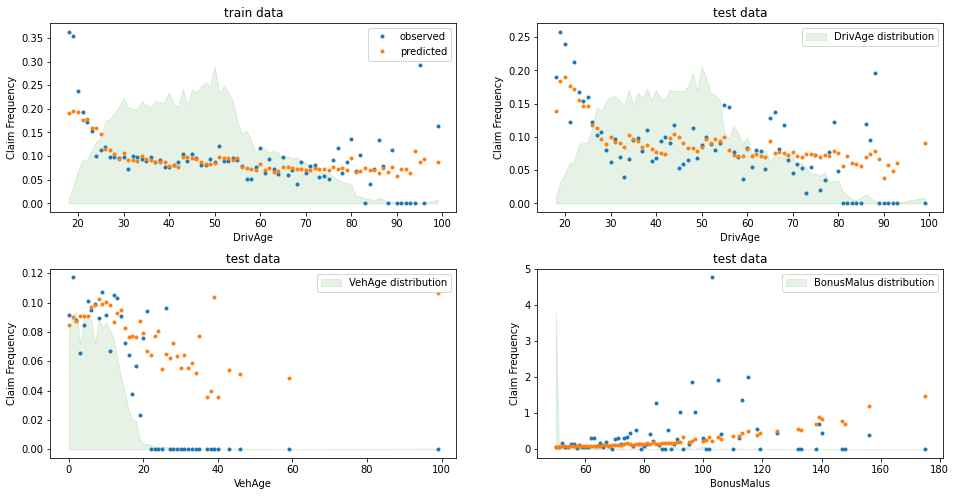

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0, 0],
)

plot_obs_pred(
    df=df_test,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 1],
    fill_legend=True
)

plot_obs_pred(
    df=df_test,
    feature="VehAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 0],
    fill_legend=True
)

plot_obs_pred(
    df=df_test,
    feature="BonusMalus",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 1],
    fill_legend=True
)

In [9]:
data_folder = os.path.join('/mnt', 'data', 'raw', 'illustration')
all_raw_files = [os.path.join(data_folder, fname)
                    for fname in os.listdir(data_folder)]
all_raw_files

['/mnt/data/raw/illustration/freMTPLfreq.csv',
 '/mnt/data/raw/illustration/freMTPLsev.csv']

In [10]:
random_state=42

In [19]:
freMTPLfreq = pd.read_csv(all_raw_files[0], encoding='utf8' )

In [20]:
freMTPLsev = pd.read_csv(all_raw_files[1], encoding='utf8' )

In [21]:
df_merged = pd.merge(freMTPLfreq, freMTPLsev, how='outer', on='PolicyID').fillna(0).set_index('PolicyID')

In [22]:
df_merged.head()

,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount
PolicyID,,,,,,,,,,
1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0.0


## EDA

In [23]:
pr = ProfileReport(df_merged)

In [24]:
pr.to_file(output_file='freMTPL.html')

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## TrainTest split

In [27]:
train, test = train_test_split(data, shuffle=True, test_size=0.2, random_state=random_state)

## Model

On commence par définir une fonction générique qui sera en capacité d'ajuster, optimiser et logger dans MLFlow les résultats de pipelines qui seront produits pour chaque essai

In [ ]:
def eval_metrics(actual, pred):
    # compute relevant metrics
    f1 = f1_score(actual, pred, average='macro')
    cr = classification_report(actual, pred)
    return f1, cr

In [30]:
def random_state_params(pipe, seed):
    """Crée un dictionnaire constitué de tous les paramètres 'random_state' d'un pipe et leur assigne une valeur unique"""
    rs = re.findall(r"[a-zA-Z\_]+_random_state", ' '.join(list(pipe.get_params().keys())))
    rs=dict.fromkeys(rs, seed)
    return rs

In [40]:
def trainPipelineMlFlow(xpName, pipeline, X_train, y_train, X_test, y_test, fixed_params={}, opti=False, iterable_params={}):
    """
    Fonction générique permettant d'entrainer et d'optimiser un pipeline sklearn
    Les paramètres et résultats sont stockés dans MLFlow
    """
  
    with mlflow.start_run(run_name=xpName):
        
        start_time = time.monotonic()  
        
        warnings.filterwarnings("ignore")
        
        # fit pipeline
        pipeline.set_params(**fixed_params)
        if not opti:
            search = pipeline
        else:
            search = RandomizedSearchCV(pipeline, iterable_params)
        search.fit(X_train, y_train)
                
        # get params
        params_to_log = fixed_params #select initial params
        if opti:
            params_to_log.update(search.best_params_) #update for optimal solution
        mlflow.log_params(params_to_log)
        
        # Evaluate metrics
        y_pred=search.predict(X_test)
        (f1_test, cr_test) = eval_metrics(y_test, y_pred)
        
        # Print out metrics
        print(xpName)
        print("params:" % params)
        print("f1_test: %s" % f1_test)
        print("  CR_test: %s" % cr_test)

        mlflow.log_metrics({"f1_test": f1_test})
        mlflow.sklearn.log_model(pipeline, xpName)
        
        end_time = time.monotonic()
        elapsed_time = timedelta(seconds=end_time - start_time)
        print('elapsed time :', elapsed_time)
        mlflow.set_tag(key="elapsed_time", value=elapsed_time)   
        